# Process of Benchmarking data

In [15]:
from IPython.display import clear_output
# !pip install forest-benchmarking
clear_output()

In [16]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [17]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')
# plt.style.use('fast')

In [18]:
# target_qubits = [0,1]
target_qubits = [41,42]
# target_qubits = [0]
n_qubits = len(target_qubits)

k_m = 200 #number of sequences
n_m = 200 #least number of shots

# max_depth = 80
max_depth = 24
min_depth = 1

epsilon = 0.01
# machine_title = '2q-qvm'
# machine_title = '_corrupted_cz_damp_0.01_depol_0.1'
machine_title = 'Aspen-M-3'
# noise_model = '_corrupted_cz_damp_0.01_depol_0.03'
# noise_model = '_corrupted_cz_damp_0.01_depol_0.03'

# noisy_machine = machine_title + noise_model
noisy_machine = machine_title
# noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)

In [19]:
path

'c:\\Users\\mohsen\\Documents\\Python_pros\\git_controlled\\Randomized_Benchmarking_protocol\\output_storage\\Aspen-M-3'

In [20]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [21]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['target qubits'] == str(target_qubits)]
    return dataframe

def filter_large_errors(dataframe):
    return dataframe[dataframe['error of fidelity'] <= 0.1]

def filter_circuit_length(dataframe):
    df = dataframe[dataframe['circuit depth'] <= max_depth]
    df = df[df['circuit depth'] >= min_depth]
    return df

def filter_seqs_shots_num(dataframe, sequences_num, shots_num):
    df = dataframe[dataframe['number of shots'] >= shots_num]
    df = df[df['number of sequences'] == sequences_num]
    return df

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

def remove_duplicated_points(dataframe):
    new_df = pd.DataFrame()
    for version in dataframe['protocol name'].unique():
        version_df = dataframe[ dataframe['protocol name'] == version ]
        new_df = new_df._append(version_df[~version_df.duplicated(['circuit depth'], keep='last')] ) 
    return new_df

In [22]:
df = capture_bench_dataframe(path)

In [23]:
df = filter_circuit_length(df)
# df = filter_large_errors(df)
df = filter_seqs_shots_num(df, sequences_num=k_m, shots_num=n_m)

In [24]:
df = remove_duplicated_points(df)

In [25]:
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = []
    err_fdlty_dict[version] = []
    ordered_layers_dict[version] = []

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version] = avg_fdlty_arr
        err_fdlty_dict[version] = err_fdlty_arr
        ordered_layers_dict[version] = ordered_layers
    except:
        raise Exception('Import Error')
        pass

In [26]:
df

,date,target qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
0,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,1,0.830325,0.039403
1,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,3,0.727381,0.065894
2,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,5,0.649744,0.052014
3,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,7,0.590706,0.049887
4,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,9,0.513981,0.051381
5,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,11,0.475381,0.052757
6,2023-07-12,"[41, 42]",200,800,native_conditional_conditional_two_qubits,13,0.460400,0.052006
8,2023-07-15,"[41, 42]",200,800,native_conditional_conditional_two_qubits,15,0.393300,0.054190
9,2023-07-15,"[41, 42]",200,800,native_conditional_conditional_two_qubits,17,0.357156,0.061509
10,2023-07-15,"[41, 42]",200,800,native_conditional_conditional_two_qubits,19,0.350425,0.043045


In [27]:
plot_labels = {'standard_rb_single_qubit':'T-designs',
               'standard_rb_two_qubits':'T-designs',
               'native_conditional_conditional_two_qubits':'Conditional method',
               'native_conditional_single_qubit':'Conditional method'}

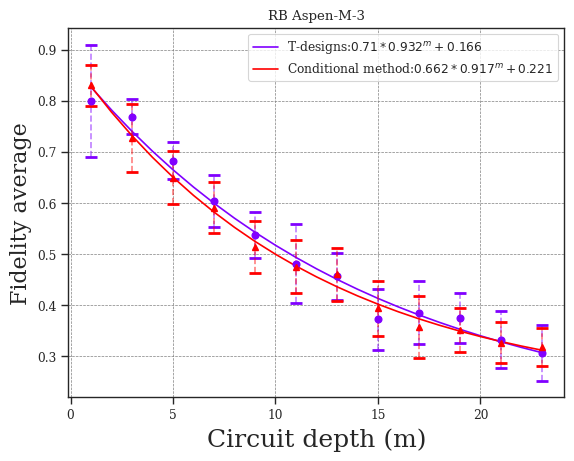

In [29]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot()
plt.grid(color='grey', linestyle='--', linewidth=0.5)

plt.style.use('fast')
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, 2))))

# Your plotting code here


fmt_list = ['o','^']
# for i,version in enumerate(['standard_rb_single_qubit', 'native_conditional_single_qubit']):
for i,version in enumerate(['standard_rb_two_qubits', 'native_conditional_conditional_two_qubits']):
# for i, version in enumerate(['native_conditional_conditional_two_qubits']):
# for version in ['native_conditional_single_qubit']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][:], avg_fdlty_dict[version][:],
               err_fdlty_dict[version][:], fmt = fmt_list[i], label = plot_labels[version], axes = ax)

# plt.loglog()
ax.set_xlabel('Circuit depth (m)', fontsize=18)
ax.set_ylabel('Fidelity average', fontsize=16)
ax.set_title(r'RB {}'.format(noisy_machine))

plt.legend()

# plt.loglog()
fig.savefig(os.path.join(path, 'RB_{}.png'.format(target_qubits)), bbox_inches = 'tight', pad_inches = 0.1)
